# Imports & Options

# Setup

Welcome to Crispr! See "Major Methods" below for an overview of a typical workflow. 

## Table of contents:
  * <a href=#Setup>Setup</a>
    * <a href=#Ojbect>Initialization of Object</a>
    * <a href=#Processing>Preprocessing & Clustering</a> 
  * <a href=#Plots>Initial Plotting</a>
  * <a href=#Analyses>Perturbation Analyses</a>
    * <a href=#Augur>Aggregate Cell-Type Perturbation Scoring (Augur)</a>
    * <a href=#Mixscape>Cell-Level Perturbation Classification & Response Scoring (Mixscape)</a>
    * <a href=#Distance>Distance Metrics</a>
    * <a href=#Composition>Compositional Analysis (scGen)</a>
    * <a href=#Dialogue>Multi-Cellular Programs (Dialogue)</a>

The `crispr.Crispr()` class is the main way of interacting with the package; however, if you want to manipulate a data object before subjecting it to the initial processing steps in the `Crispr.__init__` method for some reason, you can use `adata = cr.pp.create_object(file_path, ...)`, then pass `adata` to the class initialization method in lieu of a file/dictionary of file processing arguments.

<u> Argument Conventions: </u>

Certain arguments used throughout the `crispr` package (including outside the `crispr.crispr_class.Crispr()` class), hold to conventions intended to foster readability, maintain consistency, and promote clarity, both for end-users and future developers.

* Arguments starting in `col_` and `key_`
    - The "col_" prefix indicates that an argument refers to a column name (often in `.adata.obs` or `.adata.var`), while the "key_" prefix means you're meant to specify a type of entry in a column. For instance, assume the column "condition" contains the names of different experimental conditions (drug A, drug B, drug C). In a function where you want to compare, for instance, drug A vs. control, you would specify `key_treatment="drug A"` and k
    - These names may 
        * already exist (or will exist in the `.adata` attribute immediately upon creating the AnnData object from the data file) or 
        * may yet to be created, namely, after object initialization by running the object's methods. Thus, you may specify what you want certain columns to be named (e.g., the binary perturbed/non-perturbed column) or what entries within a column will be called (e.g., "Control" for rows within the `col_control` corresponding to cells that have control guide RNA IDs in `col_guide_rna`), for aesthetics, customizability to your design/interpretability, and/or to avoid duplicating pre-existing names.
    - These arguments will be entered as items (with the argument names as keys) in dictionaries stored in the object attributes `._columns` and `._keys`, respectively.
    - These arguments will often be passed by default (or will force them as specifications) to various object methods.
    - In certain methods, you can specify a new column to use just for that function. For instance, if you have a column containing CellTypist annotations and want to use those clusters instead of the "leiden" ones for the `run_dialogue()` method, you can specify in that method (`run_dialogue(col_cell_type="majority_voting")`) without changing the attribute (`self._columns`) that contains your original specification here.

<!-- break -->

* `col_perturbed` (binary) vs. `col_condition` (can have >= 3 categories)
    - In the `Crispr` class object, `col_perturbed` is meant to be a binary column that has `key_control` as the entry for control rows and `key_treatment` for all other experimental conditions. 
        * For instance, for a CRISPR design targeting more than one gene, `col_perturbed` would contain only `key_treatment` (i.e., all perturbed cells, regardless of targeted gene) while `col_condition` would contain entries specifying the particular gene(s) targeted (or `key_control`).
        * A drug design targeting more than one gene, `col_perturbed` would contain only `key_treatment` (i.e., all perturbed cells, regardless of targeted gene) while `col_condition` would contain entries specifying the particular gene(s) targeted (or `key_control`).
        * If the design only targets one gene/has one treatment conditions/etc., these columns would simply be equivalent.
    - In the `Crispr` class object, it is created during object initialization as a column (named after your specification of `col_perturbed`) in `.obs`. All rows in `.obs[col_condition]` that do not = `key_control` will be set as `key_treatment`.
    - In the `crispr` package more broadly, if a function calls for a `col_perturbed` argument, that indicates that it works with binary categories only. If it is fed a column with three or more categories, it will either subset the data to include only rows where that column = `key_treatment` or `key_control` (desirable behavior if you want to compare only a subset of the existing conditions, but undesirable if you want to look at, say, any drug vs. control, where the desired "drug" category consists of rows where the column = "drug A" and "drug B"), or it will throw an error.

## Initialization Method Arguments (Select)

Here are some of the important argument for the `Crispr()` class initialization method:

* `file_path`: Path or object containing data. Used in initialization to create the initial `self.adata` attribute (an AnnData or MuData object). Either
    - a path to a 10x directory (with matrix.mtx.gz, barcodes.tsv.gz, features.tsv.gz),
    - a path to an .h5ad or .mu file (Scanpy/AnnData/Muon-compatible), 
    - an AnnData or MuData object (e.g., already loaded with Scanpy or Muon, or by using `crispr.pp.create_object(file_path)`), or
    - a dictionary containing keyword arguments to pass to  `crispr.pp.combine_matrix_protospacer()` (in order to load information about perturbations from other file(s); see function documentation), or
    - to concatenate multiple datasets, a dictionary (keyed by your desired subject/sample names to be used in `col_sample_id`) consisting of whatever objects you would pass to `create_object()`'s `file` argument for the individual objects. You must also specify `col_sample` (a tuple as described in the documentation below). The other arguments passed to the `crispr.pp.create_object()` function (e.g., `col_gene_symbols`) can be specified as normal if they are common across samples; otherwise, specify them as lists in the same order as the `file` dictionary. 
* `col_sample_id`: Column in `.obs` with sample IDs. If this column does not yet exist in your data and needs to be created by concatenating datasets, you must provide
    - `file_path` as a dictionary keyed by desired `col_sample_id` values as well as 
    - signal that concatenation needs to happen by specifying `col_sample_id` as a tuple, with the second element containing a dictionary of keyword arguments to pass to `AnnData.concatenate()` or None (to use defaults).

See docstring in `crispr.crispr_object` and the README for more details.


## Crispr Object Properties

Below are descriptions of major `Crispr()` object attributes and methods.

### Attributes

* `.adata`: AnnData object. Columns or other objects created in the course of running certain methods may also be stored in its various attributes. Below are listed some of the major attributes of `.adata`. Note that for multi-modal data (self._assay is not None), some of these attributes may need to be accessed by `.adata[self._assay].<attribute>`, but for brevity, we'll refer to `.adata` here. Not all will/have to be present, except `.X`, `.obs`, and `.var`. You can access the gene expression modality directly by calling `self.rna`, whether the data are multi- or single-modal.
    -  `.X`: Sparse matrix of data originally passed to the function to create an AnnData object (e.g., from CellRanger output).
    -  `.layers`: Contains different versions of `adata.X`, such as scaled data (`adata.layers["scaled"]`) or that created by calculating a 
                  Mixscape perturbation signature (`adata.layers["X_pert"]`, by default).
    -  `.obs`: pandas.DataFrame of observations (rows=cells). You can store additional data about individual cells/samples/etc. here by assigning a new column. Can also be called directly using `self.obs`.
    -  `.obsm`: xxxxxxxxxxxxxxxxxxxxxxxxxx
    -  `.obsm`: xxxxxxxxxxxxxxxxxxxxxxxxxx
    -  `.var`: pandas.DataFrame of observations (rows=cells). You can store additional data about individual cells/samples/etc. here by assigning a new column. 
            Often contains the gene symbols and EnsemblIDs (either of which is often the index/`.var_names`),
            "feature_types" (e.g., "Gene Expression"), and, after preprocessing, may contain columns such as the number of cells expressing that feature ("n_cells"),
            whether that feature is a mitochonrial ("mt") and/or highly variable ("highly_variable") gene, mean and total counts, percent dropout, means, dispersions, 
            and normalized versions of these metrics. Can also be called directly using `self.var`.
    -  `.uns`: A dictionary that holds various results and other information. Can also be called directly using `self.uns`.
    -  `.obs_names`: Row indices of `.obs` (e.g., cell barcodes). Changing this attribute changes this index, and has other potential benefits/consequences.
    -  `.var_names`: Row indices of `.var` (i.e., gene names). Changing this attribute changes this index, and has other potential benefits/consequences.
    -  `.n_obs`: Number of observations (i.e., cells).
    -  `.n_vars`: Number of features (i.e., genes/proteins/etc.).
* `.results`: Stored output (other than figures). Note that some results may also be saved in `.obs` and `.uns` attributes of `.adata`.
* `.figures`: Stored figure objects.
* `.info`: Miscellaneous information about the object (e.g., its analysis/processing history).

### Methods

Here are the methods (applicable to scRNA-seq generally, not just perturbations) **in order** of a typical workflow _(replace ... with argument specifications)_:

* `self.preprocess(...)`: Perform filtering, normalization, scaling, quality control analysis, selection for highly variable genes, regressing out confounds, and intial exploration of the data (e.g., cell counts, mitochondrial counts, etc.).
* `self.cluster(...)`: Perform dimensionality reduction (e.g., PCA) and clustering (Louvain or Leiden), as well as related visualization.
* `self.plot(...)`: Create additional basic plots (e.g., dot, matrix, and violin gene expression plots).

The following perturbation-specific methods can be executed optionally and in any order:

* `self.run_augur(...)`: Score and plot how strongly different cell types responded to perturbation(s). This score is operationalized as the accuracy with which a machine learning model can use gene expression data to predict the perturbation condition to which cells of a given type belong. Augur provides scores aggregated across cells of a given type rather than for individual cells.
* `self.run_mixscape(...)`: Quantify and plot the extent to which individual cells responded to CRISPR perturbation(s), and identify which perturbation condition cells were not detectibly perturbed in terms of their gene expression.
* `self.compute_distance(...)`: Calculate and visualize various distance metrics that quantify the similarity in gene expression profiles across perturbation conditions.
* `self.run_composition_analysis(...)`: Analyze and visualize shifts in the cell type composition across perturbation conditions.
* `self.run_dialogue(...)`: Create plots showing multi-cellular programs.

In [1]:
%load_ext autoreload
%autoreload 2

import crispr as cr 
from crispr.crispr_class import Crispr
import pertpy as pt
import pandas as pd
import numpy as np
from config import (
    files_data, assays_data, col_cell_type_data, col_gene_symbols_data,
    col_perturbed_data, col_condition_data, key_control_data, 
    key_treatment_data, col_split_by_data, 
    col_batch_data, col_sample_id_data, 
    kws_process_guide_rna_data, col_guide_rna_data, col_num_umis_data)

# Options
pd.options.display.max_columns = 100
skip_preprocessing_clustering = False  # to skip these steps
print(dir(cr.ax))
file =  "CRISPRi_scr_multi"
# file = "CRISPRi_scr"
# file = "CRISPRi_ess"
# file = "ECCITE"
# file = "augur_ex"
# file = "coda"
# file = "screen"
# file = "perturb-seq"
kws_pca = dict(n_comps=None, use_highly_variable=True)
kws_neighbors = None  # passed to neighbors function
kws_umap = dict(min_dist=0.3)  # passed to UMAP fx
kws_cluster = dict(resolution=0.5)  # passed to louvain/leiden fx

#  Set Arguments
if file in assays_data:
    if isinstance(assays_data[file], str) or assays_data[file] is None:
        assays_data[file] = [assays_data[file], None]
    assay, assay_protein = assays_data[file]
else:
    assay, assay_protein = None
file_path = files_data[file]
col_split_by = col_split_by_data[file]
kwargs_init = dict(assay=assay, assay_protein=assay_protein,
                   col_gene_symbols=col_gene_symbols_data[file],  
                   col_cell_type=col_cell_type_data[file], 
                   col_sample_id=col_sample_id_data[file], 
                   col_batch=col_batch_data[file],
                   col_perturbed=col_perturbed_data[file], 
                   col_guide_rna=col_guide_rna_data[file], 
                   col_num_umis=col_num_umis_data[file],
                   kws_process_guide_rna=kws_process_guide_rna_data[file],
                   col_condition=col_condition_data[file], 
                   key_control=key_control_data[file], 
                   key_treatment=key_treatment_data[file],
                   remove_multi_transfected=True)
print(files_data)
if file == "default_fast":
    skip_preprocessing_clustering = True
print("\n\n\nInitialization keyword arguments:\n", kwargs_init)

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'analyze_composition', 'cluster', 'clustering', 'compute_distance', 'find_markers', 'perform_augur', 'perform_celltypist', 'perform_differential_prioritization', 'perform_gsea', 'perform_mixscape', 'perturbations']
{'CRISPRi_scr': {'directory': '/home/asline01/projects/crispr/examples/data/crispr-screening/HH03'}, 'CRISPRi_scr_multi': {'HH03': {'directory': '/home/asline01/projects/crispr/examples/data/crispr-screening/HH03'}, 'HH06': {'directory': '/home/asline01/projects/crispr/examples/data/crispr-screening/HH06'}}, 'CRISPRi_wgs': '/home/asline01/projects/crispr/examples/data/replogle_2022_k562_gwps.h5ad', 'CRISPRi_ess': '/home/asline01/projects/crispr/examples/data/replogle_2022_k562_esss.h5ad', 'pool': '/home/asline01/projects/crispr/examples/data/norman_2019_raw.h5ad', 'bulk': '/home/asline01/projects/crispr/examples/data/burczynski_crohn.h5ad', 'screen': '/home/

## Object

This code instantiates the CRISPR object, which is the main way of interacting with this package as an end-user.

This is more code than you would need in real life; it just ensures that certain public datasets are loaded from the source for various reasons.

In [2]:
print(f"Initialization arguments (from config):\n\n{kwargs_init}")
if isinstance(file, str) and file in ["ECCITE", "Adamson"]:
    self = Crispr(
        pt.data.papalexi_2021() if file == "ECCITE" else
        pt.data.adamson_2016_upr_perturb_seq(), **kwargs_init)
else:
    self = Crispr(file_path, **kwargs_init)
self.obs  # RNA assay/gene expression modality dataframe

Initialization arguments (from config):

{'assay': None, 'assay_protein': None, 'col_gene_symbols': 'gene_symbols', 'col_cell_type': 'majority_voting', 'col_sample_id': ('orig.ident', None), 'col_batch': 'orig.ident', 'col_perturbed': 'perturbation', 'col_guide_rna': 'feature_call', 'col_num_umis': 'num_umis', 'kws_process_guide_rna': {'feature_split': '|', 'guide_split': '-', 'key_control_patterns': ['CTRL']}, 'col_condition': 'target_gene_name', 'key_control': 'NT', 'key_treatment': 'KD', 'remove_multi_transfected': True}


<<<INITIALIZING CRISPR CLASS OBJECT >>>


<<< INTEGRATING >>>


	*** Creating object 1 of 2

<<< LOADING PROTOSPACER METADATA >>>


Cell Counts: Raw

15078


Gene Counts: Raw



<<<PERFORMING gRNA PROCESSING AND FILTERING>>>



UMAP Keywords: {'min_dist': 0.3}
{'kws_hvg': {'min_mean': 0.0125, 'max_mean': 10, 'min_disp': 0.5, 'flavor': 'cell_ranger'}, 'target_sum': 10000.0, 'cell_filter_pmt': [0, 15], 'cell_filter_ngene': [200, None], 'cell_filter_ncounts': [3, 40000], 'gene_filter_ncell': [3, None], 'regress_out': None, 'scale': None, 'normalization': 'z'}
*** Preprocessing batch (by_batch) HH03...

Un-Used Keyword Arguments: {'assay_protein': None, 'remove_doublets': True, 'col_condition': 'target_gene_name', 'col_target_genes': 'target_gene_name', 'col_perturbed': 'perturbation', 'col_sample_id': 'orig.ident', 'col_batch': 'orig.ident', 'col_guide_rna': 'feature_call', 'col_num_umis': 'num_umis', 'kws_umap': {'min_dist': 0.3}}


AnnData object with n_obs × n_vars = 8239 × 36549
    obs: 'num_features', 'feature_call_original', 'num_umis_original', 'feature_call', 'num_umis', 'target_gene_name', 'multiple', 'orig.ident', 'perturbation', 'n_counts', 'log_counts', 'n_genes'
    var: 'gene_ids', 'feature_types'

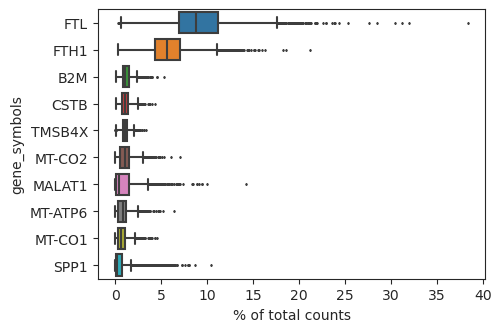


	*** Detecting Mitochondrial, Ribosomal, Hemoglobin genes...

	*** Calculating & plotting QC metrics...




... storing 'feature_call_original' as categorical
... storing 'num_umis_original' as categorical
... storing 'feature_call' as categorical
... storing 'num_umis' as categorical
... storing 'target_gene_name' as categorical
... storing 'multiple' as categorical
... storing 'perturbation' as categorical
... storing 'feature_types' as categorical


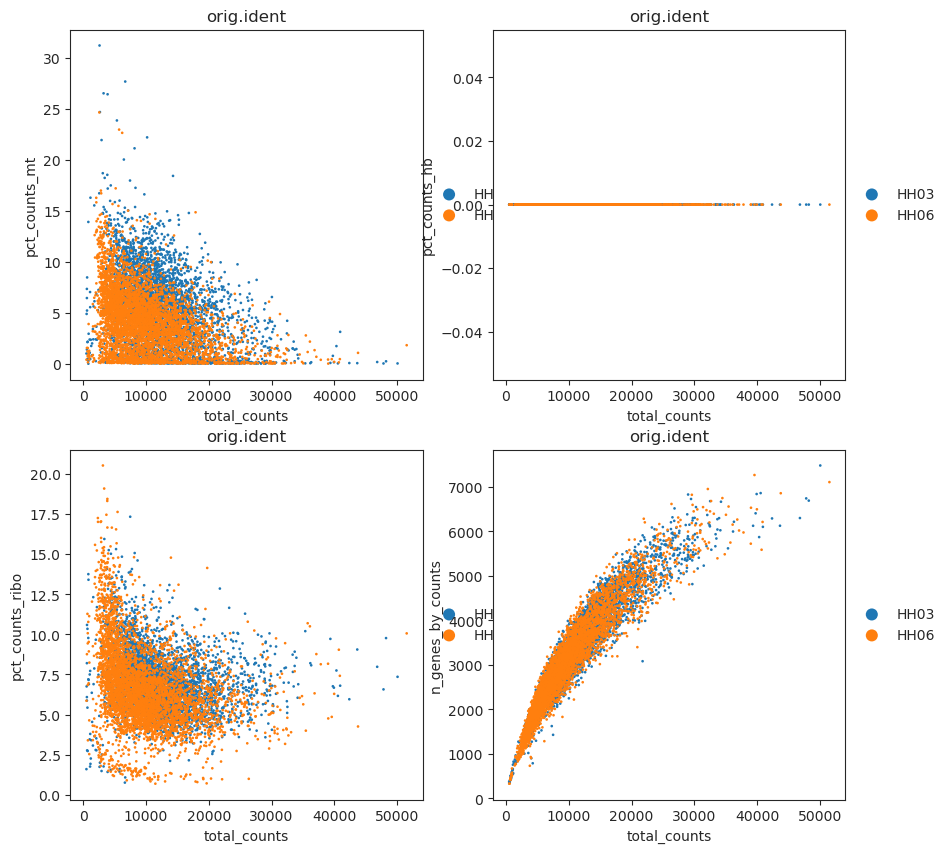

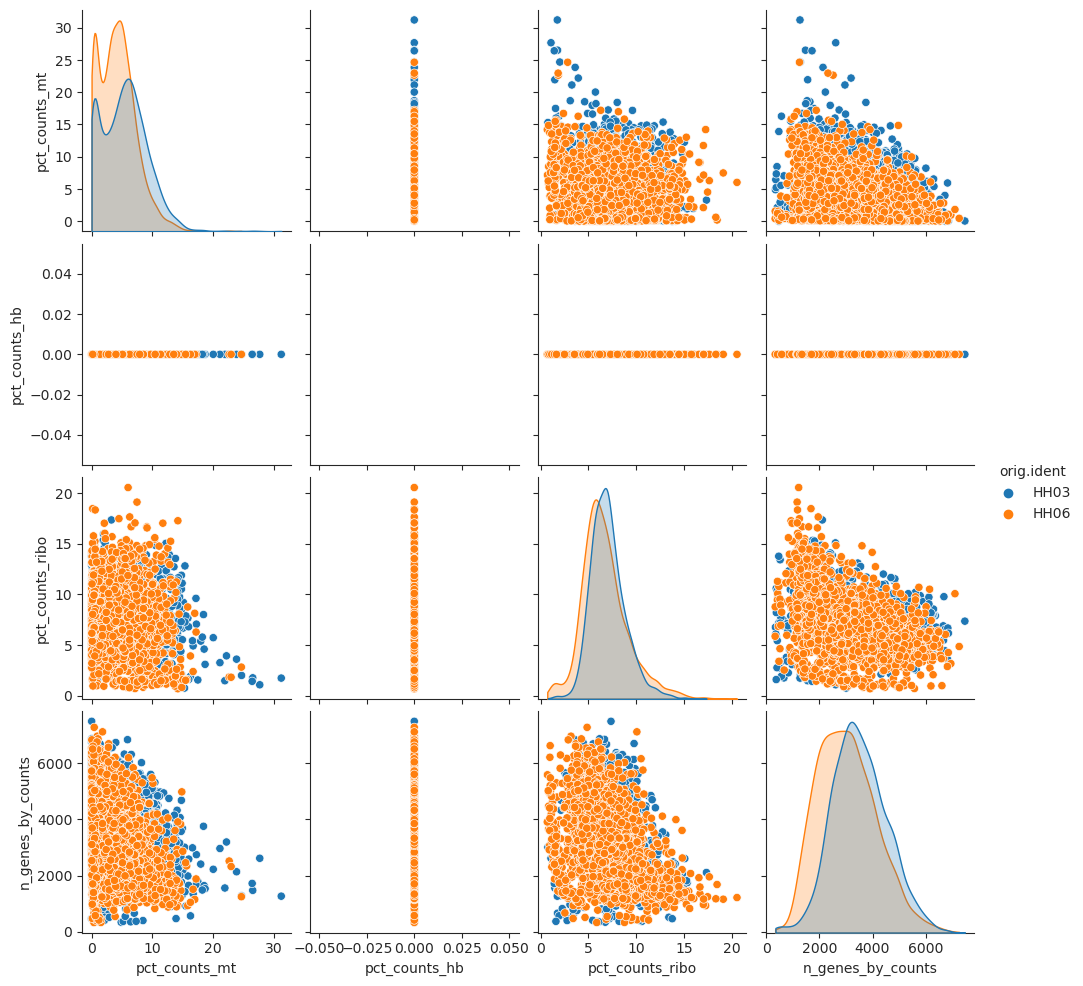

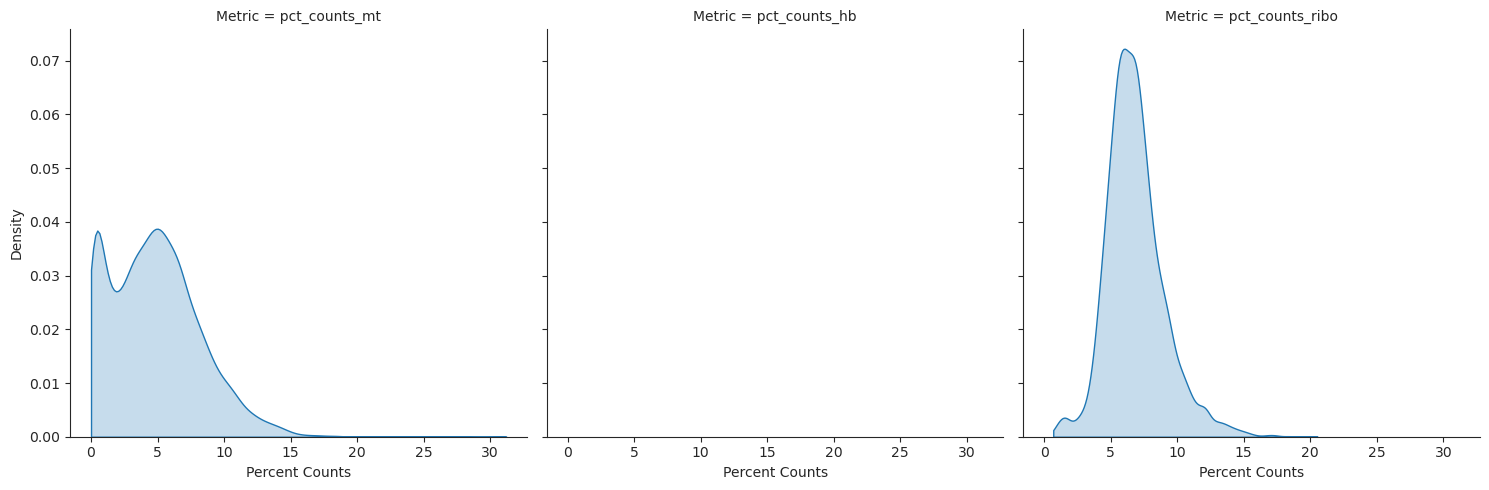

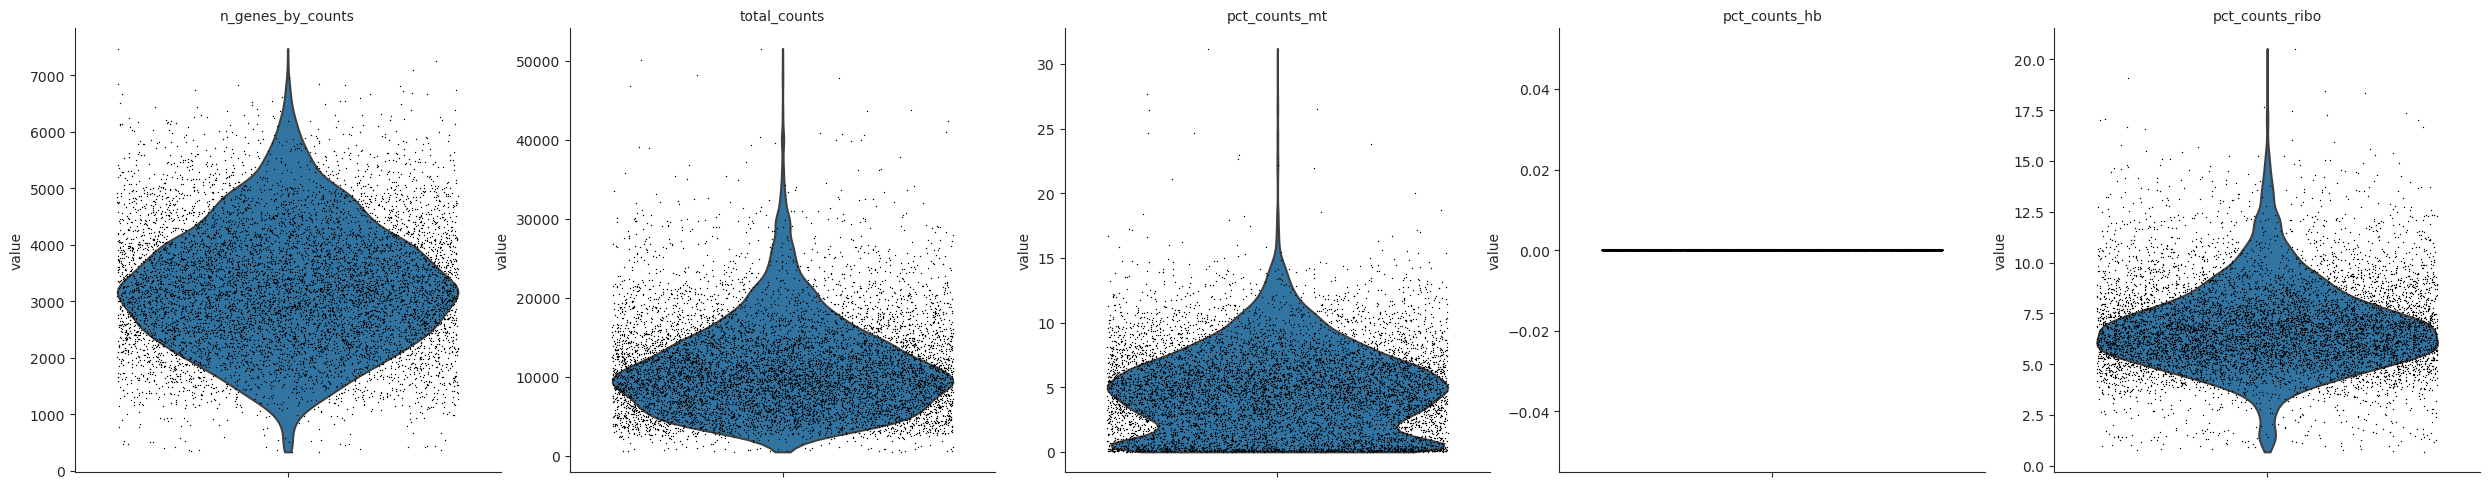

       n_cells_by_counts   mean_counts  log1p_mean_counts  \
count       36549.000000  36549.000000       36549.000000   
mean          733.661714      0.306996           0.121957   
std          1520.475938      6.704428           0.320266   
min             0.000000      0.000000           0.000000   
25%             0.000000      0.000000           0.000000   
50%            12.000000      0.001578           0.001577   
75%           610.000000      0.082777           0.079529   
max          8239.000000   1038.962769           6.946940   

       pct_dropout_by_counts  total_counts  log1p_total_counts  
count           36549.000000  3.654900e+04        36549.000000  
mean               91.095258  2.529344e+03            3.455524  
std                18.454618  5.523779e+04            3.286807  
min                 0.000000  0.000000e+00            0.000000  
25%                92.596189  0.000000e+00            0.000000  
50%                99.854351  1.300000e+01            2.6390

: 

In [ ]:
if skip_preprocessing_clustering is False:
    x
    # Arguments
    print(f"UMAP Keywords: {kws_umap}")
    
    # Preprocess
    process_kws = dict(
        kws_hvg=dict(min_mean=0.0125, max_mean=10, min_disp=0.5, 
                     flavor="cell_ranger"),  # for highly-variable gene fx
        target_sum=1e4,  # total-count normalization (1e4=10,000/cell)
        cell_filter_pmt=[0, 15],  # range of mitchondrial gene % allowed
        cell_filter_ngene=[200, None],  # cells: min/max genes expressed
        cell_filter_ncounts=[3, 40000],  # cells: min/max read range
        gene_filter_ncell=[3, None],  # genes: min/max cell count range
        regress_out=None,  # don't regress out confounds like pct_mt
        scale=None,  # don't center/standardize data using typical method
        normalization="z")  # instead, layer of z-scores ~ control means/SDs
    print(process_kws)
    self.preprocess(**process_kws, kws_umap=kws_umap)  # preprocessing
    
    # Cluster 
    self.cluster(method_cluster="leiden", kws_neighbors=kws_neighbors,
                 kws_pca=kws_pca, kws_umap=kws_umap,  kws_cluster=kws_cluster)
    
self.rna.obs

### CellTypist Cell Cluster Annotation

You can see what models are available with this code:
```
import celltypist
celltypist.models.models_description().set_index("model").description.apply(lambda x: print(x))
celltypist.models.models_description()
```

Or it will do it for you automatically if you feed it an unknown model:

```
self.annotate_clusters(model="kate_moss.pkl")
```

In [ ]:
preds, fig_ct = self.annotate_clusters(model="COVID19_HumanChallenge_Blood.pkl")
self.rna.obs

### Find Cluster Markers (DEGs)

To sort by absolute values on "scores" for cluster 6, showing the top 3 gene markers:

`clus = "6"`

`marks.loc[clus].loc[marks.loc[clus].scores.abs().sort_values(ascending=False).iloc[:3].index]`

To show the top 3 gene markers for all clusters:

`marks.groupby(marks.index.names[0]).apply(lambda x: x.scores.abs().sort_values(ascending=False).iloc[:3].index])`

In [ ]:
degs = self.find_markers(n_genes=10, method="wilcoxon", key_reference="rest")
degs[0]  # degs[1] for figures

## Inspect & Prepare

## Explore Data Descriptives

In [ ]:
_ = self.describe()  # simple
# _ = self.describe(group_by=self._columns["col_target_genes"], plot=True)

## Set Up Arguments for Later


This code looks more complicated than it actually would actually be for an end user because it was made to be generalizable across several datasets with particular column names, sizes that make it necessary to subset them in order to run the vignettes in a reasonable period of time, etc.

Basically, you won't need this code as an end user; this is just to choose random subsets of genes and perturbations, etc. that are available in a given example dataset.

In real use cases, you will know what genes and conditions are of interest, and you can manually specify them by simply stating them in the appropriate arguments (such as `target_gene_idents`) or (in many cases) by not specifying the argument (resulting in the code using all available genes, etc.).

In [ ]:
genes = self.rna.var.reset_index()[self._columns["col_gene_symbols"]]
if file == "CRISPRi_scr":
    genes_subset = [
        "CDKN2A", "CDKN1A", "PLAUR", "TP53", "IL6ST", "IL1A", "CXCL8", "CCL2", 
        "CEBPB", "NFKB1", "IGFBP7", "BCL2", "ERCC1", "ERCC4", "PTGER4", 
        "TGFB1", "ATG16L1", "NOD2", "LACC1"]
else:
    genes_subset = list(pd.Series(genes).sample(10))
target_gene_idents = list(self.obs[self._columns[
    "col_target_genes"]].sample(10))  # 10 random guide gene targets

# Plots

Create plots applicable to scRNA-seq data broadly (e.g., UMAP, dotplots) without having to do any perturbation-specific analyses.

## Basic Usage

You can create simple plots easily without having to remember a bunch of arguments to specify! 

The most useful is the `genes` argument, which allows you to subset the number of features plotted (useful for spead and layout/interpretability of plots).

In [ ]:
figs = self.plot(genes=genes_subset)

## Advanced Usage

Use the `layers` argument to plot more layers (in this instance, all of them, including the scaled data) for certain plot types.
 
Use the `cell_types_circle` argument to create a UMAP with certain cell types circled in red.

Use the `genes_highlight` argument to highlight in gold the names of specified genes on the gene expression dot plot.

Use the `kws_clustering` argument to specify a dictionary keywords to pass to certain UMAP-based plots. For instance, specify `kws_clustering=dict(col_cell_type="leiden")` to use leiden clusters instead of whatever is stored in `self._columns["col_cell_type"]`.

Use the `kws_gex_violin` argument to pass additional arguments to the violin plots of gene expression.

In [ ]:
cct = "predicted_labels" if "predicted_labels" in self.rna.obs else None
clus = list(self.rna.obs[cct].sample(2))  # clusters to circle
figs = self.plot(genes=genes_subset, 
                 col_cell_type=cct,
                 layers="all",  # also plot "scaled" layer, for instance
                 cell_types_circle=clus,  # list cell types to circle on UMAP
                 genes_highlight=list(np.array(genes_subset)[1:3]), 
                 kws_gex_violin=dict(scale="area", height=10),
                 kws_clustering=dict(col_cell_type=cct))

# Analyses

The following examples concern CRISPR or other perturbation design-specific analyses.

## Guide RNA Counts/Percentage

In [ ]:
# Choose Subset of Target Genes (optional)
tgis = list(pd.Series(target_gene_idents).sample(3)) if len(
    target_gene_idents) > 3 else target_gene_idents  # smaller subset = faster
cct = "majority_voting" if "majority_voting" in self.rna.obs else None

# Guide RNA Counts
_ = self.get_guide_rna_counts(target_gene_idents=tgis)

# ...By Cell Type
_ = self.get_guide_rna_counts(target_gene_idents=tgis, group_by=cct)

# # ...By Target Gene Ultimately Assigned
# _ = self.get_guide_rna_counts(target_gene_idents=tgis, 
#                               group_by=self._columns["col_target_genes"])

# ...By Cell Type & Target Gene Ultimately Assigned
_ = self.get_guide_rna_counts(target_gene_idents=tgis, group_by=[
    cct, self._columns["col_target_genes"]], margin_titles=True)

## Targeting Efficiency

## Augur

Cell Type-Level Perturbation Response

Which cell types are most affected by perturbations? Quantify perturbation responses by cell type with Augur, which uses supervised machine learning classification of experimental condition labels (e.g., treated versus untreated). The more separable the condition among cells of a given type, the higher the perturbation effect score.

<u> __Features__ </u>  

- Quantify and visualize degree of perturbation response by cell type
- Identify the most important features (genes).

<u> __Input__ </u>  

<u> __Output__ </u>  

mean_augur_score

<u> __Notes__ </u>  

- Sub-sample sizes equal across conditions; does not account for perturbation-induced compositional shifts (cell type abundance)
- Scores are for cell types (aggregated across cells, not individual cells)
- Two modes
    - If select_variance_feature=True, run the original Augur implementation, which removes genes that don't vary much across cell type.
    - If False, use features selected by `scanpy.pp.highly_variable_genes()`, which is faster and sensitively recovers effects; however, the feature selection may yield inflated Augur scores because this reduced feature set is used in training, resulting in it taking advantage of the pre-existing power of this feature selection to separate cell types.
    - If False, you also have to be sure that "highly_variable_features" is a variable in your data. This can be complicated if you have a separate layer for perturbation data.

In [ ]:
cct = "majority_voting" if "majority_voting" in self.rna.obs else \
    self._columns["col_cell_type"]
augur_adata, augur_results, figs_augur = self.run_augur(
    col_cell_type=cct, col_perturbed=self._columns["col_perturbed"], 
    key_treatment=self._keys["key_treatment"], select_variance_features=True,
    classifier="random_forest_classifier", n_folds=3, augur_mode="default", 
    layer_perturbation=self._layers["layer_original"], kws_umap=kws_umap, 
    subsample_size=5, kws_augur_predict=dict(span=0.7))

## Mixscape

Cell-Level Perturbation Response

**Which cell types are most affected by perturbations?** Quantify perturbation responses by cell type with Augur, which uses supervised machine learning classification of condition labels (e.g., treated versus untreated) and looking at how easy it is to tell perturbed versus non-perturbed (more separable = higher effect).

**Are there perturbation-specific clusters?** Mixscape uses linear discriminant analysis (LDA) to cluster cells that resemble each other in terms of gene expression and perturbation condition. _(LDA reduces dimensionality and attempts to maximize the separability of classes. Unperturbed cells are removed from analysis.)_

<u> __Features__ </u>  

- Remove confounds (e.g., cell cycle, batch effects)
- Classify cells as affected or unaffected (i.e., "escapees") by the perturbation
- Quantify and visualize degree of perturbation response

<u> __Input__ </u> 

See documentation, but the key arguments are listed here.

* **col_cell_type**: If you want to run using a different cell classification column, (e.g., CellTypist annotations that weren't used for the original `self._columns["col_cell_type"]``), you can specify a different column by passing `col_cell_type=<column name>` if you'd like.
* **target_gene_idents**: A list of gene symbols to focus on in plots/analyses. True to include all.

<u> __Output__ </u>  
Assuming self.run_mixscape() output is assigned to a variable `figs`:
- Targeting Efficiency: `figs["mixscape_targeting_efficacy"]`
- Differential Expression Ordered by Posterior Probabilities: `figs["mixscape_DEX_ordered_by_ppp_heat"]`
- Posterior Probabilities Violin Plot: `figs["mixscape_ppp_violin"]`
- Perturbation Scores: `figs["mixscape_perturb_score"]`
- Perturbation Clusters (from LDA): `figs["perturbation_clusters"]`

<u> __Notes__ </u>  

In [ ]:
cct = "majority_voting" if "majority_voting" in self.rna.obs else \
    self._columns["col_cell_type"]  # use CellTypist as cell type if possible
figs_mixscape = self.run_mixscape(
    col_split_by=col_split_by, col_cell_type=cct, target_gene_idents=True,
    # layer_perturbation=None
    layer_perturbation=self._layers["layer_original"]
    )

## Distance

Distance Metrics

See `self.figures["distances"]` and  `self.results["distances"]` for results.

In [ ]:
cct = "predicted_labels" if "predicted_labels" in self.rna.obs else None
kws_plot = dict(figsize=(15, 15), robust=True)  # heatmap keywords
fig_dist_w = self.compute_distance(distance_type="edistance", method="X_pca",
                                   col_cell_type=cct, kws_plot=kws_plot)

fig_dist_e = self.compute_distance(distance_type="mmd", method="X_pca",
                                   col_cell_type=cct, kws_plot=kws_plot)

## Composition

Composition Analysis

In [ ]:
oca = self.run_composition_analysis("0", est_fdr=0.05, generate_sample_level=False)

## Dialogue

Multi-Cellular Programs

In [ ]:
cct = "majority_voting" if "majority_voting" in self.rna.obs.columns else None
fig_mcp = self.run_dialogue(n_programs=4, cmap="coolwarm", col_cell_type=cct)

# TESTING WORKSPACE (IGNORE)

## Preprocessing

In [ ]:
import scanpy as sc

ann = sc.read("/home/asline01/Downloads/tmp.h5ad")
ann.obs = ann.obs.drop(kwargs_init["col_condition"], axis=1)
self = Crispr(ann.copy(), **{**kwargs_init, "col_sample_id": "orig.ident", "col_batch": "orig.ident", "kws_process_guide_rna": None})

process_kws = dict(
    kws_hvg=dict(min_mean=0.0125, max_mean=10, 
                    min_disp=0.5, filter=False, flavor="cell_ranger"),
    target_sum=1e4,  # total-count normalization (1e4=10,000/cell)
    cell_filter_pmt=[0, 15],  # range of mitchondrial gene % allowed
    cell_filter_ngene=[200, None],  # cells: min/max genes expressed
    cell_filter_ncounts=[3, 40000],  # cells: min/max read range
    gene_filter_ncell=[3, None],  # genes: min/max cell count range
    scale=None, regress_out=None,
    normalization="z")
ann, figs = self.preprocess(**process_kws, kws_umap=kws_umap, copy=True)  # preprocessing

## Composition Analysis

In [ ]:
adata = cr.pp.create_object(file_path, col_sample_id="orig.ident", col_gene_symbols=col_gene_symbols_data[file], kws_process_guide_rna={
                "col_guide_rna": kwargs_init["col_guide_rna"], "col_num_umis": kwargs_init["col_num_umis"],
                "key_control": kwargs_init["key_control"], 
                "col_guide_rna_new": kwargs_init["col_condition"], 
                "remove_multi_transfected": True, 
                **kws_process_guide_rna_data[file]})

In [ ]:
import scanpy as sc

sc.tl.embedding_density(self.rna, basis="umap", groupby=self._columns["col_perturbed"])
sc.pl.embedding_density(adata, basis="umap", key=f"umap_density_{self._columns['col_perturbed']}", group=self._keys["key_control"])
sc.pl.embedding_density(adata, basis="umap", key=f"umap_density_{self._columns['col_perturbed']}", group=self._keys["key_treatment"])
self.adata.obs[self._columns["col_perturbed"]].value_counts()

In [ ]:
col_perturbed = "perturbation"
col_cell_type = "leiden"
reference_cell_type = "0"
layer_perturbation = "original"
assay = None

scodata = self.adata.copy()
scodata.X = scodata.layers[layer_perturbation]

mod = "coda"
model = pt.tl.Sccoda()

scodata = model.load(
    scodata, type="cell_level",
    modality_key_1=assay if assay else "rna",
    modality_key_2="coda",
    generate_sample_level=True,
    cell_type_identifier=col_cell_type, 
    covariate_obs=[col_perturbed])  # load data
# mod = assay if assay else list(set(sccoda_data.mod.keys()).difference(
#     set(["coda"])))[0]  # original modality
print(scodata)
print(scodata["coda"].X)
print(scodata["coda"].obs)
scodata = model.prepare(scodata, modality_key=mod, formula=col_perturbed,
                    reference_cell_type=reference_cell_type)  # setup
model.run_nuts(scodata, modality_key=mod)  # no-U-turn HMV sampling 
model.summary(scodata, modality_key=mod)  # result

## Batch Removal

In [ ]:
import scanpy as sc

batch_adata = self.adata[self.adata.obs[self._columns["col_sample_id"]] == "HH03"].copy()
sc.pp.filter_cells(batch_adata, min_genes=200)
sc.pp.filter_genes(batch_adata, min_cells=3)
gex = batch_adata.X.A.copy()  #  sparse -> dense matrix for batch s
gex_ctrl = batch_adata[batch_adata.obs[
    "perturbation"] == "NT"].X.A.copy()  # reference condition
musd_ctrl = np.nanmean(gex_ctrl, axis=0), np.nanstd(gex_ctrl, axis=0)
batch_adata.X = (batch_adata.X.A - musd_ctrl[0]) / musd_ctrl[1]  # z

In [ ]:
train = self.adata.copy()
train.X = train.layers["original"]

train.obs["cell_type"] = train.obs["leiden"].tolist()
train.obs["batch"] = train.obs["orig.ident"].tolist()

kws_train = dict(max_epochs=100, batch_size=3, early_stopping=True, early_stopping_patience=25)

pt.tl.SCGEN.setup_anndata(train, batch_key="batch", 
                            labels_key="cell_type")  # prepare AnnData
model = pt.tl.SCGEN(train)
model.train(**kws_train)  # training
corrected_adata = model.batch_removal()  # batch correction

ann = cr.pp.remove_batch_effects(ann, col_cell_type="leiden", col_batch=self._columns["col_sample_id"],
                                 **kws_train)